### Gridflow process
This walkthrough highlights the main steps: importing dependencies, configuring inputs, partitioning countries into zones, summarizing zonal data, building the flow network, and producing EPM-ready CSVs.

#### Step 1: imports (see `README.md` for installation hints)
Only bring in the plotting tools and Gridflow modules that the notebook actually uses; consult `README.md` if you encounter dependency issues.

In [1]:
# To help debug import errors
if False:
    import sys
    print("Python executable:", sys.executable)
    print("sys.path:", sys.path[0])
    !conda list

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path

from gridflow import model, epm_input_generator
from gridflow.visuals import country_viz, flow_field_heatmap

plt.style.use('fivethirtyeight')

#### Step 2: user inputs
Centralize the dataset paths, countries, and modeling configuration so you can adjust everything before running the workflow. Use the optional `zone_stats_to_load` list to pick which zonal datasets get computed (leave it as `["population"]` or set to `None` to include everything).

In [3]:
# dataset locations and region configuration
data_path = 'data/global_datasets'  # path containing borders, rasters, and grid.gpkg

countries = ["LUX"]  # ISO3 codes for the countries to model
n_zones = 5  # target number of zones per the region

# epm
epm_input_raw = 'data/epm_inputs_raw'  # raw EPM CSV templates
epm_output_dir = 'data/epm_inputs'  # destination for zonalized CSVs

# zonal statistics to compute (None for all available)
zone_stats_to_load = ['population']

method_zoning = "pv"

# renewables.ninja API TLS (leave defaults unless you need a custom CA)

#### Step 3: build the region and create zones
Instantiate the region object for the selected countries and segment it into the requested number of zones to prepare the spatial structure.

In [4]:
region = model.region(countries, data_path, zone_stats_to_load=zone_stats_to_load)

region.create_zones(n=n_zones, method=method_zoning)

##### Inspect the zoning results
Review the geopandas table that describes each zone so you can verify the segmentation before enriching it.

In [5]:
region.zones

,geometry,country
0,"POLYGON ((6.01667 50.18333, 6.01667 50.175, 5....",LUX
1,"POLYGON ((6.00833 49.90833, 6.00833 49.9, 5.98...",LUX
2,"POLYGON ((6.20833 49.89167, 6.20833 49.88333, ...",LUX
3,"MULTIPOLYGON (((6.36667 49.85, 6.36667 49.8416...",LUX
4,"MULTIPOLYGON (((5.99167 49.69167, 5.99167 49.6...",LUX


#### Step 5: enrich zones and compute statistics
Populate the zones with aggregated datasets (population, renewables) and use the built-in stats to summarize key metrics.

In [6]:
region.set_zone_data(verbose=True)
region.zone_stats

Loading zone stat 'population' from data/global_datasets/population_2020.tif
Saved stats to region.zone_stats with columns: ['population']
Loading renewables profiles for each zone from renewables.ninja (default: pv).
  - Querying zone 0
  - Querying zone 1
  - Querying zone 2
  - Querying zone 3
  - Querying zone 4
Saved renewables profiles to region.zone_re


,population
0,100577.015625
1,50612.015625
2,200653.359375
3,188002.625000
4,516025.562500


#### Step 6: create and visualize the network
Generate the zone-to-zone flow network, visualize it on the country map, and display the computed flow matrix.

(<Figure size 700x500 with 2 Axes>,
 <Axes: title={'center': 'Flow field for the generated network'}, xlabel='To zone', ylabel='From zone'>)

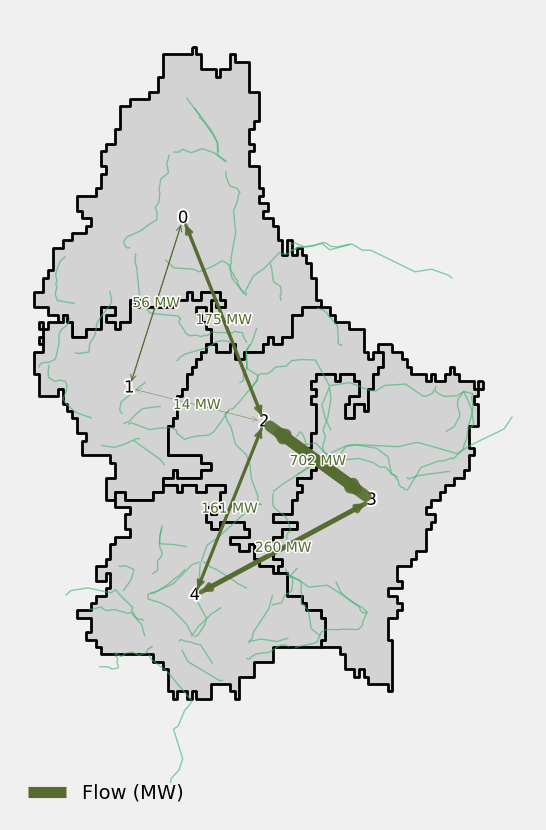

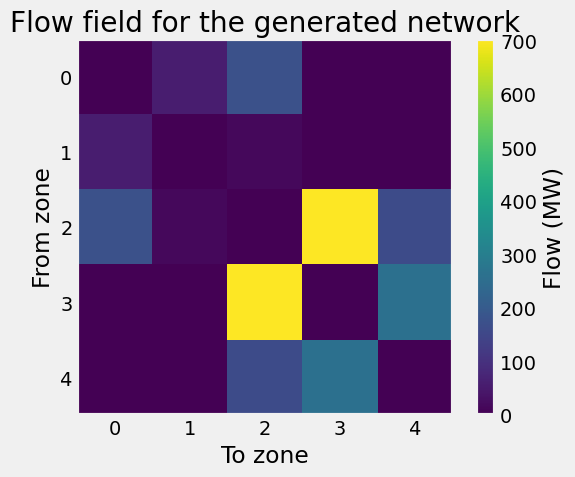

In [7]:
region.create_network()

country_viz(region, show_arrows=True, show_flow_values=True)

flow_field_heatmap(region)


#### Step 7: auto-transform inputs for EPM
Once the zone split and network are defined, run the EPM input generator to reshape the raw CSV templates into zonal files that match `region.zones`.

In [8]:
epm_input_generator.generate_epm_inputs(region, epm_input_raw, epm_output_dir)
print(f'Zonal inputs written to {Path(epm_output_dir).resolve()}')

                zone    type   2025   2030   2035   2040   2045   2050
0             Angola  Energy  17080  21782  27265  33615  41004  49537
1           Cameroon  Energy   7978   9950  12436  15534  19395  24206
2                CAR  Energy    191    459    775   1088   1348   1631
3               Chad  Energy    336    414    487    559    633    709
4              Congo  Energy   2786   3749   4923   6352   8086  10208
5          DRC_total  Energy  15462  18791  22692  26777  31629  36208
6   EquatorialGuinea  Energy    921   1168   1443   1748   2093   2485
7              Gabon  Energy   3788   4844   6128   7464   9064  10736
8             Angola    Peak   2874   3665   4587   5655   6899   8334
9           Cameroon    Peak   1294   1614   2018   2520   3147   3927
10               CAR    Peak     68    139    187    241    276    311
11              Chad    Peak     77     91    103    114    125    135
12             Congo    Peak    498    671    881   1137   1447   1826
13    

KeyError: 'country'

#### Next steps
Adjust the user inputs, explore additional metrics, or export region-aware artifacts for downstream modeling after these core steps complete.